# **Models**

**Pretrained ViT + MoE**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, List

# ----------------------------
# LoRA Expert
# ----------------------------
class LoRAExpert(nn.Module):
    """Single LoRA expert (same as before)"""
    def __init__(self, dim, r=8, alpha=16, dropout=0.1):
        super().__init__()
        self.scaling = alpha / r
        self.fc1 = nn.Linear(dim, r, bias=False)
        self.fc2 = nn.Linear(r, dim, bias=False)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        nn.init.kaiming_uniform_(self.fc1.weight, a=5**0.5)
        nn.init.zeros_(self.fc2.weight)

    def forward(self, x):
        return self.scaling * self.fc2(self.dropout(self.act(self.fc1(x))))

# ----------------------------
# Top-K Router / Gating Network
# ----------------------------
class GatingNetwork(nn.Module):
    """Gating network for MoE"""
    def __init__(self, input_dim: int, num_experts: int, top_k: int = 2):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # [batch, num_experts]
        gate_logits = self.gate(x)
        top_k_gates, top_k_indices = torch.topk(gate_logits, self.top_k, dim=-1)
        top_k_gates = F.softmax(top_k_gates, dim=-1)
        return top_k_gates, top_k_indices

# ----------------------------
# MoE-LoRA Adapter
# ----------------------------
class MoELoRA(nn.Module):
    """Mixture-of-Experts LoRA adapter parallel to frozen MLP"""
    def __init__(self, dim, num_experts=4, top_k=2, r=8, alpha=16):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k

        # Create multiple LoRA experts
        self.experts = nn.ModuleList([LoRAExpert(dim, r, alpha) for _ in range(num_experts)])
        self.router = GatingNetwork(dim, num_experts, top_k)

    def forward(self, x):
        # x: [batch, seq_len, dim] or [batch, dim]
        orig_shape = x.shape
        if x.dim() == 3:
            # flatten batch and seq for routing: [B*S, D]
            x_flat = x.reshape(-1, x.shape[-1])
        else:
            x_flat = x

        # Router -> top-k gates and indices
        top_k_gates, top_k_indices = self.router(x_flat)  # [B*S, top_k], [B*S, top_k]

        # Accumulate expert outputs
        expert_out = torch.zeros_like(x_flat)
        for i in range(self.top_k):
            idx = top_k_indices[:, i]  # [B*S]
            g = top_k_gates[:, i].unsqueeze(-1)  # [B*S, 1]

            # select corresponding experts
            expert_outputs = torch.stack([self.experts[j](x_flat) for j in range(self.num_experts)], dim=0)  # [num_experts, B*S, D]
            selected = expert_outputs[idx, torch.arange(x_flat.shape[0]), :]  # [B*S, D]

            expert_out += g * selected

        # restore original shape
        expert_out = expert_out.view(*orig_shape)
        return expert_out

# ----------------------------
# MLP + MoE-LoRA block
# ----------------------------
class MLPWithMoELoRA(nn.Module):
    """Frozen MLP + parallel MoE LoRA"""
    def __init__(self, mlp, dim, num_experts=4, top_k=2, r=8, alpha=16):
        super().__init__()
        self.mlp = mlp
        self.moe = MoELoRA(dim, num_experts, top_k, r, alpha)
        # Freeze original MLP
        for p in self.mlp.parameters():
            p.requires_grad = False

    def forward(self, x):
        return self.mlp(x) + self.moe(x)

# ----------------------------
# Replace ViT block with MoE-LoRA
# ----------------------------
class ViTBlockWithMoELoRA(nn.Module):
    """ViT block with frozen attention and MLP + MoE-LoRA"""
    def __init__(self, block, r=8, alpha=16, num_experts=4, top_k=2):
        super().__init__()
        self.norm1 = block.norm1
        self.attn = block.attn
        self.norm2 = block.norm2
        for p in self.attn.parameters():
            p.requires_grad = False

        dim = block.attn.qkv.in_features
        self.mlp = MLPWithMoELoRA(block.mlp, dim, num_experts, top_k, r, alpha)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


# --------------------------------------------------
# Embedding Model Wrapper
# --------------------------------------------------
class ViTEmbeddingModel(nn.Module):
    def __init__(self, backbone, embed_dim=512):
        super().__init__()
        self.backbone = backbone
        self.backbone.reset_classifier(0)  # remove classification head
        self.embedding = nn.Linear(backbone.num_features, embed_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        return x

# **ROI Extraction**

In [ ]:
# Install the official Google MediaPipe (known good version)
!pip install mediapipe==0.10.13


In [ ]:
# google_roi.py
"""
Hand-ROI extractor based on MediaPipe Hands (single hand, 21 landmarks).

Public API
----------
extract_palm_roi(image: numpy.ndarray) -> (roi_bgr, annotated_bgr, hand_type)

• roi_bgr          – cropped palm ROI (BGR)
• annotated_bgr    – same size as input with landmarks & box drawn
• hand_type        – "Left" / "Right" / "Unknown"
"""

import cv2
import numpy as np
import mediapipe as mp

# ----------------------------------------------------------------------
# Internal helpers
# ----------------------------------------------------------------------

def _run_mp_hands(image, min_det_conf=0.2):
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=min_det_conf
    ) as hands:
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
        if not res.multi_hand_landmarks:
            return None, None

        lm = res.multi_hand_landmarks[0]
        handedness = (
            res.multi_handedness[0].classification[0].label
            if res.multi_handedness else "Unknown"
        )

        h, w = image.shape[:2]
        pts = [(int(p.x * w), int(p.y * h)) for p in lm.landmark]
        return pts, handedness


def _midpoints(pairs):
    return [((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2) for p1, p2 in pairs]


def _calculate_point_c(m1, m2, thumb):
    m1, m2, thumb = map(np.asarray, (m1, m2, thumb))

    O = (m1 + m2) / 2.0
    AB = m2 - m1
    L = np.linalg.norm(AB)
    if L == 0:
        raise ValueError("Midpoints coincide")

    ABu = AB / L
    perp = np.array([-ABu[1], ABu[0]])

    # ---- NumPy 2.0–safe 2D cross product (scalar z-component)
    cross_z = ABu[0] * (thumb - O)[1] - ABu[1] * (thumb - O)[0]
    if cross_z < 0:
        perp = -perp

    C = O + 1.8 * L * perp
    return int(C[0]), int(C[1])  # ensure Python ints


def _extract_roi(img, mid1, mid2, C, thumb, hand_type):
    vec = np.array(mid2) - np.array(mid1)
    angle = np.degrees(np.arctan2(vec[1], vec[0]))

    C = (int(C[0]), int(C[1]))  # OpenCV-safe center

    if hand_type.lower() == "right":
        if np.dot(vec, np.array(thumb) - np.array(C)) > 0:
            angle += 180
    else:  # left / unknown
        if np.dot(vec, np.array(thumb) - np.array(C)) < 0:
            angle += 180

    side = np.linalg.norm(vec) * 2.5
    rect = (C, (side, side), angle)

    M = cv2.getRotationMatrix2D(C, angle, 1.0)
    rot = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    roi = cv2.getRectSubPix(rot, (int(side), int(side)), C)

    box = cv2.boxPoints(rect).astype(int)
    return roi, box

# ----------------------------------------------------------------------
# Public function
# ----------------------------------------------------------------------

def extract_palm_roi(image_bgr):
    """
    Parameters
    ----------
    image_bgr : np.ndarray
        BGR image.

    Returns
    -------
    roi_bgr, annotated_bgr, hand_type
        If landmarks fail → returns (None, None, None)
    """
    lms, hand_type = _run_mp_hands(image_bgr)
    if lms is None:
        return None, None, None

    idx = lambda i: lms[i]

    mids4 = _midpoints([
        (idx(17), idx(18)),
        (idx(14), idx(13)),
        (idx(10), idx(9)),
        (idx(6),  idx(5))
    ])

    adj = _midpoints([
        (mids4[0], mids4[1]),
        (mids4[1], mids4[2]),
        (mids4[2], mids4[3])
    ])

    roi_mid1 = ((adj[0][0] + adj[1][0]) / 2,
                (adj[0][1] + adj[1][1]) / 2)

    roi_mid2 = ((adj[1][0] + adj[2][0]) / 2,
                (adj[1][1] + adj[2][1]) / 2)

    thumb = idx(2)
    C = _calculate_point_c(roi_mid1, roi_mid2, thumb)

    roi, box = _extract_roi(image_bgr, roi_mid1, roi_mid2, C, thumb, hand_type)

    # Annotated image
    ann = image_bgr.copy()
    for x, y in lms:
        cv2.circle(ann, (x, y), 3, (0, 255, 0), -1)

    cv2.polylines(ann, [box], True, (0, 255, 0), 2)
    cv2.circle(ann, C, 6, (0, 0, 255), -1)

    return roi, ann, hand_type


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


(161, 161, 3)


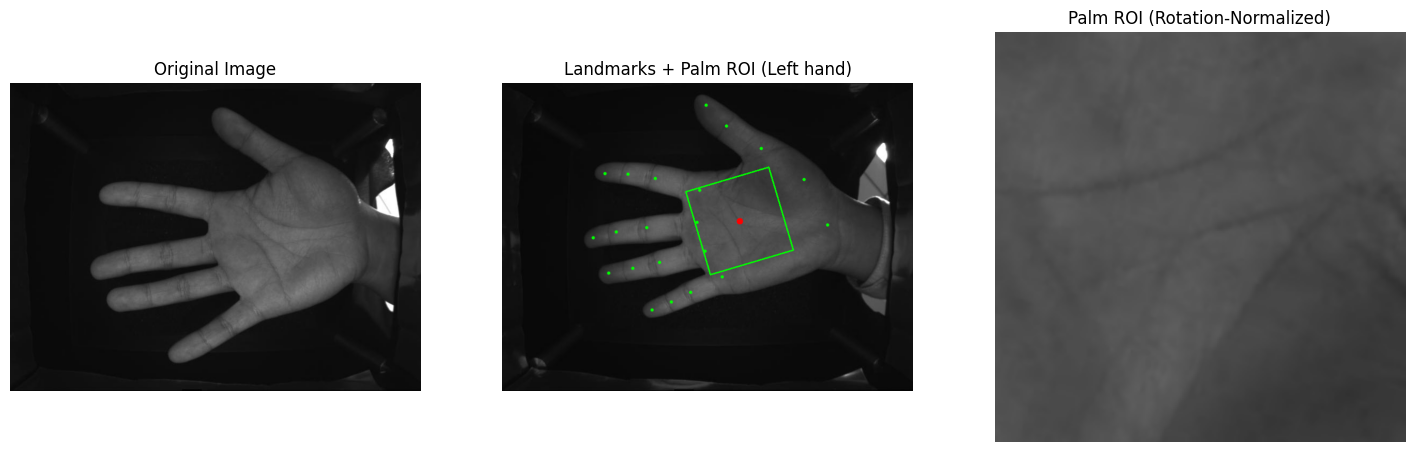

In [ ]:
# --------------------------------
# Palm ROI extraction (NEW method)
# --------------------------------
img_path = "/content/drive/MyDrive/CASIA-MS/018_r_WHT_02.jpg"
image = cv2.imread(img_path)
roi, annotated_image, hand_type = extract_palm_roi(image)
print(roi.shape)
if roi is not None:
    roi_resized = cv2.resize(roi, (224, 224))
else:
    roi_resized = np.zeros((224, 224, 3), dtype=np.uint8)



plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title(f"Landmarks + Palm ROI ({hand_type} hand)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(roi_resized, cv2.COLOR_BGR2RGB))
plt.title("Palm ROI (Rotation-Normalized)")
plt.axis("off")

plt.show()


In [ ]:
roi_resized.shape

(224, 224, 3)

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

# ================================
# Paths
# ================================
SRC_ROOT = "/content/drive/MyDrive/CASIA-MS"
DST_ROOT = "/content/drive/MyDrive/CASIA-MS-ROI"

os.makedirs(DST_ROOT, exist_ok=True)


# ================================
# Collect all images
# ================================
all_images = []
for root, _, files in os.walk(SRC_ROOT):
    for f in files:
        if f.lower().endswith(".jpg"):
            all_images.append(os.path.join(root, f))

print(f"Total images found: {len(all_images)}")


# ================================
# Counters
# ================================
num_success = 0
num_failed = 0


# ================================
# Batch processing
# ================================
for src_path in tqdm(all_images):
    rel_path = os.path.relpath(src_path, SRC_ROOT)
    dst_path = os.path.join(DST_ROOT, rel_path)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)

    # ---- Load image (RGB)
    img_rgb = np.array(Image.open(src_path).convert("RGB"))

    # ---- Convert to BGR for ROI extractor
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    # ---- Extract palm ROI (advanced method)
    roi_bgr, _, _ = extract_palm_roi(img_bgr)

    # ---- Check extraction result
    if roi_bgr is None:
        num_failed += 1
        roi_bgr = img_bgr  # fallback
        roi_bgr = cv2.resize(roi_bgr, (160, 160))
    else:
        num_success += 1
        roi_bgr = cv2.resize(roi_bgr, (160, 160))

    # ---- Save ROI
    cv2.imwrite(dst_path, roi_bgr)


# ================================
# Final report
# ================================
print("ROI extraction completed.")
print(f"Successfully extracted ROIs : {num_success}")
print(f"Failed extractions (fallback used): {num_failed}")
print(f"Success rate: {100.0 * num_success / len(all_images):.2f}%")


Total images found: 7200


100%|██████████| 7200/7200 [1:43:04<00:00,  1.16it/s]

ROI extraction completed.
Successfully extracted ROIs : 7199
Failed extractions (fallback used): 1
Success rate: 99.99%


# **Data**

**CASIA-MS**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import os
import numpy as np
from PIL import Image
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, Subset

class CASIA_MS_Dataset(Dataset):
    VALID_DOMAINS = {"460", "630", "700", "850", "940", "WHT"}

    def __init__(self, data_path):
        self.samples = []
        self.hand_id_map = {}
        self.domain_map = {}

        hand_id_counter = 0
        domain_counter = 0

        for root, _, files in os.walk(data_path):
            for fname in files:
                if not fname.lower().endswith(".jpg"):
                    continue

                # Expected: ID_{l|r}_{domain}_{iteration}.jpg
                # Example: 001_l_460_06.jpg
                name = fname[:-4]
                parts = name.split("_")

                if len(parts) != 4:
                    continue

                subject_id, hand, domain, iteration = parts

                if hand not in ("l", "r"):
                    continue

                if domain not in self.VALID_DOMAINS:
                    continue

                hand_id = f"{subject_id}_{hand}"

                if hand_id not in self.hand_id_map:
                    self.hand_id_map[hand_id] = hand_id_counter
                    hand_id_counter += 1

                if domain not in self.domain_map:
                    self.domain_map[domain] = domain_counter
                    domain_counter += 1

                img_path = os.path.join(root, fname)
                self.samples.append(
                    (
                        img_path,
                        self.hand_id_map[hand_id],   # identity label
                        self.domain_map[domain],    # domain label
                    )
                )

        # Safety check
        if len(self.samples) == 0:
            raise RuntimeError(
                "No valid samples found. "
                "Check directory and filename format: ID_l_460_06.jpg"
            )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, y_i, y_d = self.samples[idx]

        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        # ROI already extracted → just resize
        img_np = cv2.resize(img_np, (224,224), interpolation=cv2.INTER_LINEAR)

        img_tensor = (
            torch.from_numpy(img_np)
            .float()
            .permute(2, 0, 1) / 255.0
        )

        return img_tensor, y_i, y_d



# ================================
# Dataset usage
# ================================
data_path = "/content/drive/MyDrive/CASIA-MS-ROI"
dataset = CASIA_MS_Dataset(data_path)

num_classes = len(dataset.hand_id_map)
num_domains = len(dataset.domain_map)

print("Total samples:", len(dataset))
print("Hand ID classes:", num_classes)
print("Domains:", dataset.domain_map)


Total samples: 7198
Hand ID classes: 200
Domains: {'460': 0, '700': 1, 'WHT': 2, '630': 3, '850': 4, '940': 5}


In [43]:
# ================================
# Cross-Domain Split Configuration
# ================================

# Choose domains by NAME: 460, 630, 700, WHT, 850, 940
train_domains = ["940", "460", "WHT"]   # training spectra
test_domains  = ["700"]          # unseen test spectrum

# Reverse domain map: id → name
inv_domain_map = {v: k for k, v in dataset.domain_map.items()}

train_indices = []
test_indices = []

for idx, (_, _, y_d) in enumerate(dataset.samples):
    domain_name = inv_domain_map[y_d]

    if domain_name in train_domains:
        train_indices.append(idx)
    elif domain_name in test_domains:
        test_indices.append(idx)

# ================================
# Subsets
# ================================
train_dataset = Subset(dataset, train_indices)
test_dataset  = Subset(dataset, test_indices)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

# ================================
# DataLoaders
# ================================
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# ================================
# Sanity Check
# ================================
images, y_i, y_d = next(iter(train_loader))

# Verify domain separation
train_domains_seen = set(inv_domain_map[d.item()] for d in y_d)
print("Domains seen in train batch:", train_domains_seen)


images, y_i, y_d = next(iter(test_loader))

# Verify domain separation
test_domains_seen = set(inv_domain_map[d.item()] for d in y_d)
print("Domains seen in test batch:", test_domains_seen)


Train samples: 3599
Test samples: 1200
Domains seen in train batch: {'940', 'WHT', '460'}
Domains seen in test batch: {'700'}


# **Model**

In [31]:
pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=78bca721d365c84541aedbc46fa35eda1afe132e150ce4b2824f9ddc82c8c993
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=1a1fe817148f97e776eaf5989f3bafe80917c0ad67c6b53d6792bfd5a2b438f7
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [ ]:
# !pip install timm fvcore  # Run this if you haven't installed them yet

import torch
import timm
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# 1. Load the specific test_vit model
# 'test_vit.r160_in1k' is a tiny ViT trained on ImageNet-1k at 160x160
model = timm.create_model('test_vit2.r160_in1k', pretrained=True)
model.eval()

# 2. Create a dummy input matching the model's native resolution
# Format: (Batch Size, Channels, Height, Width)
dummy_input = torch.randn(1, 3, 160, 160)

# 3. Analyze FLOPs
flops = FlopCountAnalysis(model, dummy_input)
gflops = flops.total() / 1e9

# 4. Analyze Parameters
params = sum(p.numel() for p in model.parameters())

print(f"--- Model: test_vit2.r160_in1k ---")
print(f"Input Resolution: 160x160")
print(f"Total Parameters: {params / 1e6:.4f} Million")
print(f"Total Inference Cost: {gflops:.4f} GFLOPs")

# Optional: Print a detailed layer-by-layer parameter table
#print(parameter_count_table(model))

blocks.0.attn.attn_drop, blocks.1.attn.attn_drop, blocks.2.attn.attn_drop, blocks.3.attn.attn_drop, blocks.4.attn.attn_drop, blocks.5.attn.attn_drop, blocks.6.attn.attn_drop, blocks.7.attn.attn_drop


--- Model: test_vit2.r160_in1k ---
Input Resolution: 160x160
Total Parameters: 0.4557 Million
Total Inference Cost: 0.0386 GFLOPs


In [32]:
import torch
import torch.nn as nn
from fvcore.nn import FlopCountAnalysis, parameter_count_table

class CustomCNN160(nn.Module):
    def __init__(self, input_channels=3):
        super(CustomCNN160, self).__init__()

        # --- Feature Extraction ---
        self.features = nn.Sequential(
            # Output: 16 x 40 x 40 -> MaxPool: 16 x 39 x 39
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=4, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=2, stride=1),

            # Output: 32 x 19 x 19 -> MaxPool: 32 x 18 x 18
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=2, stride=1),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            # Output: 128 x 18 x 18 -> MaxPool: 128 x 17 x 17
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

        # --- Fully Connected Layers ---
        self.flatten = nn.Flatten()

        # Calculation: 128 * 17 * 17 = 36992
        self.classifier = nn.Sequential(
            nn.Linear(41472, 1024),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 128)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# --- Analysis Cell ---
model = CustomCNN160()
model.eval()
dummy_input = torch.randn(1, 3, 160, 160)

flops = FlopCountAnalysis(model, dummy_input)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"--- Baseline CNN Analysis (160x160) ---")
print(f"Total Parameters: {total_params / 1e6:.2f} Million")
print(f"Inference Cost:   {flops.total() / 1e9:.4f} GFLOPs")

--- Baseline CNN Analysis (160x160) ---
Total Parameters: 43.16 Million


Inference Cost:   0.0821 GFLOPs


In [ ]:
import torch
import torch.nn as nn
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# --------------------------------------------------
# 1. Standard Attention Class
# --------------------------------------------------
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=True):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

# --------------------------------------------------
# 2. Normal ViT Block (Standard)
# --------------------------------------------------
class TimmStyleBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=3.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(dim)

        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class CustomViTBackbone(nn.Module):
    def __init__(self, img_size=160, patch_size=16, in_chans=3,
                 embed_dim=64, depth=6, num_heads=8, mlp_ratio=3.0):
        super().__init__()

        # ADD THIS LINE:
        self.embed_dim = embed_dim

        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        self.blocks = nn.ModuleList([
            TimmStyleBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.patch_embed(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        return x[:, 0]


class ViTEmbeddingModel(nn.Module):
    def __init__(self, backbone, embed_dim=512):
        super().__init__()
        self.backbone = backbone
        # We use the embed_dim (64) we defined in our CustomViTBackbone
        # No need for reset_classifier because we built it without a head
        self.embedding = nn.Linear(backbone.embed_dim, embed_dim)

    def forward(self, x):
        # Backbone returns the [B, 64] CLS token embedding
        x = self.backbone(x)
        # Project it to [B, 512] for ArcFace
        x = self.embedding(x)
        return x



# --- Analysis Cell ---
model = CustomViTBackbone()
model.eval()

dummy_input = torch.randn(1, 3, 160, 160)
flops = FlopCountAnalysis(model, dummy_input)
param_table = parameter_count_table(model, max_depth=2)

print(f"--- Standard ViT Backbone Analysis (160x160) ---")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.4f} Million")
print(f"Inference Cost:   {flops.total() / 1e9:.4f} GFLOPs")
#print(f"Output Shape:     {model(dummy_input).shape}") # Should be [1, 64]
#print("\nDetailed Breakdown:")
#print(param_table)

# **Main**

In [5]:
pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 4.0 MB/s eta 0:00:00


**Pretrained Model**

In [44]:
# ----------------------------
# Main Script for Custom ViT + MoE-LoRA + ArcFace
# ----------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import timm
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from pytorch_metric_learning.losses import ArcFaceLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# Backbone: DeiT + MoE-LoRA
# ================================
backbone = timm.create_model(
    "deit_tiny_patch16_224",
    pretrained=True,
    num_classes=0
)

# Freeze backbone
for p in backbone.parameters():
    p.requires_grad = False

# Replace blocks with MoE-LoRA
for i, block in enumerate(backbone.blocks):
    backbone.blocks[i] = ViTBlockWithMoELoRA(
        block,
        r=8,
        alpha=16,
        num_experts=4,
        top_k=2
    )

# ================================
# Embedding Model
# ================================
embedding_dim = 512
model = ViTEmbeddingModel(backbone, embed_dim=embedding_dim).to(device)

# ================================
# Dataset Split: Train / Eval
# ================================
# full_train_dataset MUST already exist
train_ratio = 0.9
num_train = int(len(train_dataset) * train_ratio)
num_eval = len(train_dataset) - num_train

train_dataset, eval_dataset = random_split(
    train_dataset,
    [num_train, num_eval],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
eval_loader  = DataLoader(eval_dataset,  batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=4)

# ================================
# ArcFace Loss & Optimizer
# ================================
num_classes = 200
criterion = ArcFaceLoss(
    num_classes=num_classes,
    embedding_size=embedding_dim,
    margin=0.5,
    scale=10
).to(device)

optimizer = optim.AdamW(
    list(model.parameters()) + list(criterion.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

# ================================
# Training + Evaluation Loop
# ================================
epochs = 50

for epoch in range(epochs):

    # -------- Training --------
    model.train()
    train_correct, total_train = 0, 0

    for images, y_i, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, y_i = images.to(device), y_i.to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        loss = criterion(embeddings, y_i)
        loss.backward()
        optimizer.step()

        preds = criterion.get_logits(embeddings).argmax(dim=1)
        train_correct += (preds == y_i).sum().item()
        total_train += y_i.size(0)

    train_acc = train_correct / total_train

    # -------- Evaluation (20% held-out from train) --------
    model.eval()
    eval_correct, total_eval = 0, 0

    with torch.no_grad():
        for images, y_i, _ in tqdm(eval_loader, desc=f"Epoch {epoch+1} [Eval]"):
            images, y_i = images.to(device), y_i.to(device)
            embeddings = model(images)

            preds = criterion.get_logits(embeddings).argmax(dim=1)
            eval_correct += (preds == y_i).sum().item()
            total_eval += y_i.size(0)

    eval_acc = eval_correct / total_eval

    # -------- Test --------
    test_correct, total_test = 0, 0

    with torch.no_grad():
        for images, y_i, _ in tqdm(test_loader, desc=f"Epoch {epoch+1} [Test]"):
            images, y_i = images.to(device), y_i.to(device)
            embeddings = model(images)

            preds = criterion.get_logits(embeddings).argmax(dim=1)
            test_correct += (preds == y_i).sum().item()
            total_test += y_i.size(0)

    test_acc = test_correct / total_test

    # -------- Report --------
    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Acc: {train_acc:.4f} | "
        f"Eval Acc: {eval_acc:.4f} | "
        f"Test Acc: {test_acc:.4f}"
    )


Epoch 1 [Test]: 100%|██████████| 19/19 [00:05<00:00,  3.43it/s]


Epoch [1/50] | Train Acc: 0.0299 | Eval Acc: 0.1139 | Test Acc: 0.0725


Epoch 2 [Test]: 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch [2/50] | Train Acc: 0.2652 | Eval Acc: 0.3694 | Test Acc: 0.2325


Epoch 3 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.30it/s]


Epoch [3/50] | Train Acc: 0.5597 | Eval Acc: 0.5861 | Test Acc: 0.4042


Epoch 4 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s]


Epoch [4/50] | Train Acc: 0.7567 | Eval Acc: 0.6889 | Test Acc: 0.4983


Epoch 5 [Test]: 100%|██████████| 19/19 [00:04<00:00,  3.88it/s]


Epoch [5/50] | Train Acc: 0.8672 | Eval Acc: 0.8083 | Test Acc: 0.5942


Epoch 6 [Test]: 100%|██████████| 19/19 [00:05<00:00,  3.30it/s]


Epoch [6/50] | Train Acc: 0.9268 | Eval Acc: 0.8806 | Test Acc: 0.6150


Epoch 7 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s]


Epoch [7/50] | Train Acc: 0.9623 | Eval Acc: 0.9222 | Test Acc: 0.6683


Epoch 8 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.21it/s]


Epoch [8/50] | Train Acc: 0.9781 | Eval Acc: 0.9167 | Test Acc: 0.7292


Epoch 9 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.17it/s]


Epoch [9/50] | Train Acc: 0.9883 | Eval Acc: 0.9500 | Test Acc: 0.7367


Epoch 10 [Test]: 100%|██████████| 19/19 [00:05<00:00,  3.41it/s]


Epoch [10/50] | Train Acc: 0.9957 | Eval Acc: 0.9528 | Test Acc: 0.7500


Epoch 11 [Test]: 100%|██████████| 19/19 [00:05<00:00,  3.79it/s]


Epoch [11/50] | Train Acc: 0.9978 | Eval Acc: 0.9556 | Test Acc: 0.7358


Epoch 12 [Train]:  63%|██████▎   | 32/51 [00:11<00:06,  2.74it/s]


KeyboardInterrupt: 

**Custom Model**

In [41]:
# ----------------------------
# Main Script for Custom ViT + MoE-LoRA + ArcFace
# ----------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import timm
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from pytorch_metric_learning.losses import ArcFaceLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================================
# Backbone Model
# ================================
model = CustomCNN160().to(device)


# ================================
# Dataset Split: Train / Eval
# ================================
# full_train_dataset MUST already exist
train_ratio = 0.9
num_train = int(len(train_dataset) * train_ratio)
num_eval = len(train_dataset) - num_train

train_dataset, eval_dataset = random_split(
    train_dataset,
    [num_train, num_eval],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
eval_loader  = DataLoader(eval_dataset,  batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=4)

# ================================
# ArcFace Loss & Optimizer
# ================================
num_classes = 200
criterion = ArcFaceLoss(
    num_classes=num_classes,
    embedding_size=128,
    margin=0.3,
    scale=20
).to(device)

optimizer = optim.AdamW(
    list(model.parameters()) + list(criterion.parameters()),
    lr=0.5e-3,
    weight_decay=1e-4
)

# ================================
# Training + Evaluation Loop
# ================================
epochs = 50

for epoch in range(epochs):

    # -------- Training --------
    model.train()
    train_correct, total_train = 0, 0

    for images, y_i, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, y_i = images.to(device), y_i.to(device)

        optimizer.zero_grad()
        embeddings = model(images)
        loss = criterion(embeddings, y_i)
        loss.backward()
        optimizer.step()

        preds = criterion.get_logits(embeddings).argmax(dim=1)
        train_correct += (preds == y_i).sum().item()
        total_train += y_i.size(0)

    train_acc = train_correct / total_train

    # -------- Evaluation (20% held-out from train) --------
    model.eval()
    eval_correct, total_eval = 0, 0

    with torch.no_grad():
        for images, y_i, _ in tqdm(eval_loader, desc=f"Epoch {epoch+1} [Eval]"):
            images, y_i = images.to(device), y_i.to(device)
            embeddings = model(images)

            preds = criterion.get_logits(embeddings).argmax(dim=1)
            eval_correct += (preds == y_i).sum().item()
            total_eval += y_i.size(0)

    eval_acc = eval_correct / total_eval

    # -------- Test --------
    test_correct, total_test = 0, 0

    with torch.no_grad():
        for images, y_i, _ in tqdm(test_loader, desc=f"Epoch {epoch+1} [Test]"):
            images, y_i = images.to(device), y_i.to(device)
            embeddings = model(images)

            preds = criterion.get_logits(embeddings).argmax(dim=1)
            test_correct += (preds == y_i).sum().item()
            total_test += y_i.size(0)

    test_acc = test_correct / total_test

    # -------- Report --------
    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Acc: {train_acc:.4f} | "
        f"Eval Acc: {eval_acc:.4f} | "
        f"Test Acc: {test_acc:.4f}"
    )


Epoch 1 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s]


Epoch [1/50] | Train Acc: 0.0052 | Eval Acc: 0.0083 | Test Acc: 0.0050


Epoch 2 [Test]: 100%|██████████| 19/19 [00:03<00:00,  4.93it/s]


Epoch [2/50] | Train Acc: 0.0056 | Eval Acc: 0.0000 | Test Acc: 0.0050


Epoch 3 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s]


Epoch [3/50] | Train Acc: 0.0052 | Eval Acc: 0.0028 | Test Acc: 0.0050


Epoch 4 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.15it/s]


Epoch [4/50] | Train Acc: 0.0046 | Eval Acc: 0.0028 | Test Acc: 0.0050


Epoch 5 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


Epoch [5/50] | Train Acc: 0.0037 | Eval Acc: 0.0000 | Test Acc: 0.0050


Epoch 6 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


Epoch [6/50] | Train Acc: 0.0046 | Eval Acc: 0.0056 | Test Acc: 0.0050


Epoch 7 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


Epoch [7/50] | Train Acc: 0.0022 | Eval Acc: 0.0056 | Test Acc: 0.0050


Epoch 8 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.66it/s]


Epoch [8/50] | Train Acc: 0.0043 | Eval Acc: 0.0000 | Test Acc: 0.0050


Epoch 9 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.05it/s]


Epoch [9/50] | Train Acc: 0.0031 | Eval Acc: 0.0000 | Test Acc: 0.0058


Epoch 10 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s]


Epoch [10/50] | Train Acc: 0.0043 | Eval Acc: 0.0139 | Test Acc: 0.0050


Epoch 11 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]


Epoch [11/50] | Train Acc: 0.0086 | Eval Acc: 0.0056 | Test Acc: 0.0108


Epoch 12 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


Epoch [12/50] | Train Acc: 0.0130 | Eval Acc: 0.0056 | Test Acc: 0.0092


Epoch 13 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


Epoch [13/50] | Train Acc: 0.0157 | Eval Acc: 0.0056 | Test Acc: 0.0092


Epoch 14 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


Epoch [14/50] | Train Acc: 0.0198 | Eval Acc: 0.0111 | Test Acc: 0.0225


Epoch 15 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


Epoch [15/50] | Train Acc: 0.0395 | Eval Acc: 0.0361 | Test Acc: 0.0367


Epoch 16 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.51it/s]


Epoch [16/50] | Train Acc: 0.0991 | Eval Acc: 0.1000 | Test Acc: 0.0725


Epoch 17 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.64it/s]


Epoch [17/50] | Train Acc: 0.2365 | Eval Acc: 0.2083 | Test Acc: 0.1300


Epoch 18 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]


Epoch [18/50] | Train Acc: 0.4597 | Eval Acc: 0.4500 | Test Acc: 0.2658


Epoch 19 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s]


Epoch [19/50] | Train Acc: 0.7542 | Eval Acc: 0.6611 | Test Acc: 0.3550


Epoch 20 [Test]: 100%|██████████| 19/19 [00:03<00:00,  4.96it/s]


Epoch [20/50] | Train Acc: 0.9136 | Eval Acc: 0.7750 | Test Acc: 0.4442


Epoch 21 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


Epoch [21/50] | Train Acc: 0.9855 | Eval Acc: 0.8444 | Test Acc: 0.5483


Epoch 22 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


Epoch [22/50] | Train Acc: 0.9975 | Eval Acc: 0.8833 | Test Acc: 0.5867


Epoch 23 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


Epoch [23/50] | Train Acc: 0.9994 | Eval Acc: 0.8944 | Test Acc: 0.5792


Epoch 24 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.48it/s]


Epoch [24/50] | Train Acc: 0.9991 | Eval Acc: 0.8861 | Test Acc: 0.5800


Epoch 25 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]


Epoch [25/50] | Train Acc: 1.0000 | Eval Acc: 0.9028 | Test Acc: 0.6408


Epoch 26 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


Epoch [26/50] | Train Acc: 1.0000 | Eval Acc: 0.9056 | Test Acc: 0.6392


Epoch 27 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.54it/s]


Epoch [27/50] | Train Acc: 1.0000 | Eval Acc: 0.9056 | Test Acc: 0.6408


Epoch 28 [Test]: 100%|██████████| 19/19 [00:04<00:00,  4.47it/s]


Epoch [28/50] | Train Acc: 1.0000 | Eval Acc: 0.9083 | Test Acc: 0.6475


Epoch 29 [Test]: 100%|██████████| 19/19 [00:03<00:00,  4.99it/s]


Epoch [29/50] | Train Acc: 1.0000 | Eval Acc: 0.9083 | Test Acc: 0.6492


Epoch 30 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


Epoch [30/50] | Train Acc: 1.0000 | Eval Acc: 0.9139 | Test Acc: 0.6542


Epoch 31 [Test]: 100%|██████████| 19/19 [00:03<00:00,  5.55it/s]


Epoch [31/50] | Train Acc: 1.0000 | Eval Acc: 0.9111 | Test Acc: 0.6550


Epoch 32 [Train]:  59%|█████▉    | 30/51 [00:05<00:03,  5.26it/s]


KeyboardInterrupt: 

In [25]:
import os

def save_model_to_drive(model, save_path, filename="palmprint_moe_vit_roi_42.pth"):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    full_path = os.path.join(save_path, filename)

    # Save the weights (state_dict)
    # Moving to CPU before saving is a best practice for compatibility
    torch.save(model.state_dict(), full_path)
    print(f"✅ Model weights successfully saved to: {full_path}")

# Usage:
DRIVE_PATH = '/content/drive/MyDrive/SIT_Palmprint_Project'
save_model_to_drive(model, DRIVE_PATH)

✅ Model weights successfully saved to: /content/drive/MyDrive/SIT_Palmprint_Project/palmprint_moe_vit_roi_42.pth


In [26]:
def load_moe_vit_model(checkpoint_path, device, num_experts=4, top_k=2):
    # 1. Rebuild the exact same architecture
    backbone = timm.create_model(
    "deit_tiny_patch16_224",
    pretrained=True,
    num_classes=0
    )
    for i, block in enumerate(backbone.blocks):
        backbone.blocks[i] = ViTBlockWithMoELoRA(
            block,
            r=8,
            alpha=16,
            num_experts=num_experts,
            top_k=top_k
        )

    # 2. Wrap and move to device
    model = ViTEmbeddingModel(backbone, embed_dim=512).to(device)

    # 3. Load the weights
    if os.path.exists(checkpoint_path):
        # map_location=device handles the CPU -> GPU transfer if needed
        state_dict = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state_dict, strict=True)
        print("✅ Weights loaded and architecture matched successfully.")
    else:
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    return model

# Usage for TTA:
CHECKPOINT = os.path.join(DRIVE_PATH, 'palmprint_moe_vit_roi_42.pth')
model = load_moe_vit_model(CHECKPOINT, device, num_experts=4, top_k=2)

✅ Weights loaded and architecture matched successfully.


In [27]:
# --------------------------------------------------------------------------------
# Test-Time Adaptation (Episodic Entropy Minimization)
# --------------------------------------------------------------------------------
print("\nStarting Global TTA Evaluation...")

# 1. Create a CPU backup for episodic reset
# Since 'model' is already loaded via load_moe_vit_model, we clone its current state.
cpu_reset_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# 2. Freeze all parameters except MoE Experts/Routers
for p in model.parameters():
    p.requires_grad = False

for name, p in model.named_parameters():
    if any(k in name.lower() for k in ["lora", "expert", "gate", "router"]):
        p.requires_grad = True

total_baseline_acc = 0.0
total_tta_acc = 0.0
num_batches = len(test_loader)

# 3. Iterate through all batches
for images, labels, _ in tqdm(test_loader, desc="TTA on Test Set"):
    images, labels = images.to(device), labels.to(device)

    # --- Step A: Episodic Reset ---
    # Return to the clean, trained state for every new batch
    model.load_state_dict(cpu_reset_state)

    # --- Step B: Baseline Check (Before TTA) ---
    model.eval()
    with torch.no_grad():
        embeddings = model(images)
        logits = criterion.get_logits(embeddings)
        baseline_batch_acc = (logits.argmax(dim=1) == labels).float().mean().item()
        total_baseline_acc += baseline_batch_acc

    # --- Step C: Perform TTA (Entropy Minimization) ---
    # Optimizer specifically for MoE/LoRA parameters
    tta_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    model.train()
    for _ in range(20): # 20 steps based on your BS=32 observations
        tta_optimizer.zero_grad()
        embeddings = model(images)
        logits = criterion.get_logits(embeddings)
        probs = F.softmax(logits, dim=1)

        # Entropy loss calculation: -sum(p * log(p))
        entropy_loss = -torch.sum(probs * torch.log(probs + 1e-6), dim=1).mean()
        entropy_loss.backward()
        tta_optimizer.step()

    # --- Step D: Inference (After TTA) ---
    model.eval()
    with torch.no_grad():
        embeddings = model(images)
        logits = criterion.get_logits(embeddings)
        tta_batch_acc = (logits.argmax(dim=1) == labels).float().mean().item()
        total_tta_acc += tta_batch_acc

# 4. Final Results Summary
final_baseline = total_baseline_acc / num_batches
final_tta = total_tta_acc / num_batches

print("\n" + "="*40)
print(f"FINAL TTA RESULTS ({num_batches} Batches)")
print(f"Average Baseline Acc: {final_baseline:.4f}")
print(f"Average TTA Acc:      {final_tta:.4f}")
print(f"Absolute Improvement: {final_tta - final_baseline:.4f}")
print("="*40)


Starting Global TTA Evaluation...


TTA on Test Set: 100%|██████████| 19/19 [01:41<00:00,  5.35s/it]


FINAL TTA RESULTS (19 Batches)
Average Baseline Acc: 0.9701
Average TTA Acc:      0.9942
Absolute Improvement: 0.0241
